In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from scipy.optimize import least_squares
from functools import partial

In [2]:
import os

output_dir = "out/"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [3]:
data = pd.read_csv("logs/positions.csv")

data.head()

,id,idx,x,y,comment
0,9,8,10.473627,-4.045105,localization
1,8,7,10.197010,3.665844,localization
2,7,6,5.906242,1.653850,localization
3,6,5,6.071673,1.856514,localization
4,4,4,-7.756449,2.706479,localization


In [4]:
localization = data[data["comment"] == "localization"]
final = data[data["comment"] == "final"]
real = data[data["comment"] == "real"]

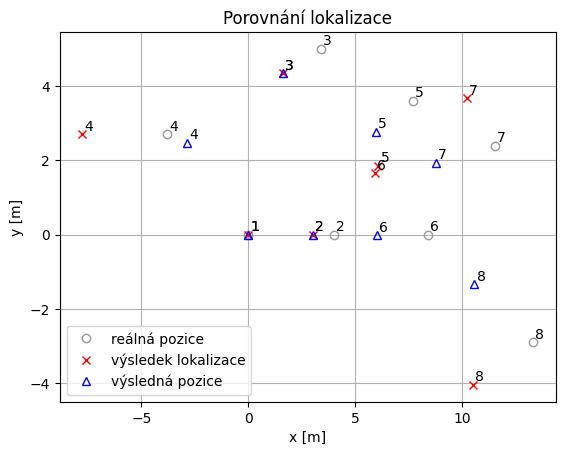

In [5]:
fig, ax = plt.subplots()
ax.plot(real["x"], real["y"],"o", fillstyle="none", color="0.6", label="reálná pozice")
ax.plot(localization["x"], localization["y"],"xr", label="výsledek lokalizace")
ax.plot(final["x"], final["y"],"^b", fillstyle="none", label="výsledná pozice")
for i in range(data.shape[0]):
    ax.annotate(data.iloc[i]["idx"], (data.iloc[i]["x"] + 0.1,data.iloc[i]["y"] + 0.1))
ax.legend()
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Porovnání lokalizace')
ax.grid()
plt.show()
fig.savefig(f"{output_dir}finding-color-locations.png", dpi=300)

In [6]:
def draw_multilateration(data, alt_data, colors=["black","red","green","blue","orange","yellow","deepskyblue","pink"]):
    color_idx = 0
    fig, ax = plt.subplots()
    ax.plot(alt_data["x"], alt_data["y"],"o", color="0.6")
    for i in range(alt_data.shape[0]):
        ax.annotate(alt_data.iloc[i]["id"], (alt_data.iloc[i]["x"],alt_data.iloc[i]["y"]))
    for i in range(data.shape[0]):
        ax.plot(data.iloc[i]["x"], data.iloc[i]["y"],"o",color=colors[color_idx])
        ax.annotate(data.iloc[i]["id"], (data.iloc[i]["x"],data.iloc[i]["y"]))
        if data.iloc[i]["dist"] != np.nan:
            ax.add_patch(plt.Circle((data.iloc[i]["x"],data.iloc[i]["y"]), data.iloc[i]["dist"], alpha=0.08, color=colors[color_idx]))
            ax.add_patch(plt.Circle((data.iloc[i]["x"],data.iloc[i]["y"]), data.iloc[i]["dist"], fill=False, color=colors[color_idx]))
        color_idx += 1
        if color_idx >= len(colors):
            color_idx = 0
    ax.set_aspect('equal', adjustable='box')

In [7]:
def make_equations(anchors):
    if len(anchors) < 2:
        return None, None
    A = np.ndarray((len(anchors)-1, 2))
    b = np.ndarray((len(anchors)-1))
    for i in range(1,len(anchors)):
        A[i-1, 0] = anchors[i]["x"] - anchors[0]["x"]
        A[i-1, 1] = anchors[i]["y"] - anchors[0]["y"]
        b[i-1] = 0.5 * (anchors[0]["dist"]**2 - anchors[i]["dist"]**2 + (anchors[i]["x"]**2 + anchors[i]["y"]**2) - (anchors[0]["x"]**2 + anchors[0]["y"]**2))
    return A, b

In [8]:
def draw_multilateration_equations(anchors, pos, border=5, colors=["black","red","green","blue","orange","yellow","deepskyblue","pink"]):
    A, b = make_equations(anchors)
    if A is None or b is None:
        return None, None
    color_idx = 0
    fig, ax = plt.subplots()
    for i,anchor in enumerate(anchors):
        ax.plot(anchor["x"], anchor["y"],"o",color=colors[color_idx])
        ax.annotate(i, (anchor["x"],anchor["y"]))
        # draw circles
        ax.add_patch(plt.Circle((anchor["x"],anchor["y"]), anchor["dist"], alpha=0.08, color=colors[color_idx]))
        ax.add_patch(plt.Circle((anchor["x"],anchor["y"]), anchor["dist"], fill=False, color=colors[color_idx]))
        # draw linear equations
        if i != 0:
            if A[i-1,0] == 0:
                x_intercept = b[i-1]/0.000000001 # approximation
            else:
                x_intercept = b[i-1]/A[i-1,0]
            if A[i-1,1] == 0:
                y_intercept = b[i-1]/0.000000001 # approximation
            else:
                y_intercept = b[i-1]/A[i-1,1]
            ax.axline((0, y_intercept), (x_intercept,0), color=colors[color_idx])
            print(f"A={A[i-1]}, b = {b[i-1]}")
            print(f"{(0, y_intercept)}, {(x_intercept,0)}, color={colors[color_idx]}")
        color_idx += 1
        if color_idx >= len(colors):
            color_idx = 0
    ax.plot(pos[0], pos[1], "*", markersize=10, markerfacecolor="yellow", markeredgewidth=1, markeredgecolor="black", label="výsledek multilaterace")
    ax.set_aspect('equal', adjustable='box')
    
    # custom bounds
    x_limits = [pos[0], pos[0]]
    y_limits = [pos[1], pos[1]]
    for anchor in anchors:
        x_limits[0] = min(x_limits[0], anchor["x"] - anchor["dist"])
        x_limits[1] = max(x_limits[1], anchor["x"] + anchor["dist"])
        y_limits[0] = min(y_limits[0], anchor["y"] - anchor["dist"])
        y_limits[1] = max(y_limits[1], anchor["y"] + anchor["dist"])
    ax.set_xlim((x_limits[0] - border, x_limits[1] + border))
    ax.set_ylim((y_limits[0] - border, y_limits[1] + border))
    ax.legend()
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    return fig, ax

In [9]:
# Levenberg-Marquardt Non-linear least squares
def lma(anchors):
    def jacobian(locs, x):
        dxy = (locs[:,0] - x[0])**2 + (locs[:,1] - x[1])**2
        dxy[dxy == 0] = 1e-6
        return (locs - x) / np.sqrt(dxy).reshape(-1,1)
    def residuals(locs, dists, x):
        return dists - np.sqrt((locs[:,0] - x[0])**2 + (locs[:,1] - x[1])**2)
    locations = np.ndarray((len(anchors), 2))
    distances = np.ndarray((len(anchors)))
    for i,anchor in enumerate(anchors):
        locations[i,0] = anchor["x"]
        locations[i,1] = anchor["y"]
        distances[i] = anchor["dist"]
    
    # make initial guess - average of x and y coordinates of 2 closest anchors
    sorted_dists_idx = np.argsort(distances)
    x0 = (locations[sorted_dists_idx[0]][0] + locations[sorted_dists_idx[1]][0])/2
    y0 = (locations[sorted_dists_idx[0]][1] + locations[sorted_dists_idx[1]][1])/2

    res = least_squares(partial(residuals, locations, distances), np.array([x0, y0]), partial(jacobian, locations), method="lm")
    return res.x

In [10]:
anchor_good = pd.read_json("logs/001a.json")
print(f"{anchor_good.shape=}")
anchor_good.head(2)

anchor_good.shape=(30, 5)


,timestamp_start,timestamp_end,anchors,chosen_anchors,result_pos
0,3041070,3041350,[],[],"[0.0, 0.0]"
1,3041980,3042320,"[{'x': 6.01, 'y': -0.01, 'dist': 2.45}, {'x': ...","[{'x': 6.01, 'y': -0.01, 'dist': 2.45}, {'x': ...","[10.19701, 3.665844]"


A=[-0.04  2.78], b = 0.5079999999999956
(0, 0.1827338129496387), (-12.699999999999878, 0), color=red
A=[-3.01  0.01], b = -27.787300000000002
(0, -2778.73), (9.231661129568108, 0), color=green
A=[-4.41  4.35], b = -23.088250000000002
(0, -5.307643678160921), (5.235430839002268, 0), color=blue
A=[-6.01  0.01], b = -66.9769
(0, -6697.69), (11.144242928452579, 0), color=orange


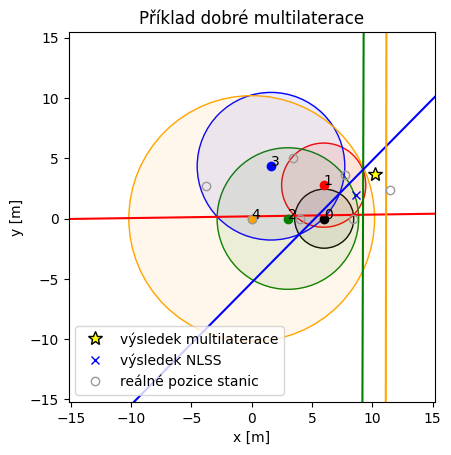

In [11]:
fig,ax = draw_multilateration_equations(anchor_good.iloc[-1]["chosen_anchors"], anchor_good.iloc[-1]["result_pos"])
lma_pos = lma(anchor_good.iloc[-1]["chosen_anchors"])
ax.plot(lma_pos[0], lma_pos[1], "xb", label="výsledek NLSS")
ax.plot(real.iloc[-7:]["x"], real.iloc[-7:]["y"], "o", fillstyle="none", color="0.6", label="reálné pozice stanic")
ax.legend()
ax.set_title("Příklad dobré multilaterace")
fig.savefig(f"{output_dir}finding-color-localization-error.png", dpi=300)

In [12]:
anchor_outlier = pd.read_json("logs/000b.json")
print(f"{anchor_outlier.shape=}")
anchor_outlier.head()

anchor_outlier.shape=(31, 5)


,timestamp_start,timestamp_end,anchors,chosen_anchors,result_pos
0,511220,511410,[],[],"[0.0, 0.0]"
1,512020,512200,"[{'x': 1.6, 'y': 4.34, 'dist': 5.67}, {'x': 3....","[{'x': 0.0, 'y': 0.0, 'dist': 3.07}, {'x': 1.6...","[-7.756449, 2.706479]"
2,512780,513070,"[{'x': 1.6, 'y': 4.34, 'dist': 5.67}, {'x': 3....","[{'x': 0.0, 'y': 0.0, 'dist': 3.07}, {'x': 1.6...","[-7.756449, 2.706479]"
3,513630,513860,"[{'x': 1.6, 'y': 4.34, 'dist': 5.67}, {'x': 3....","[{'x': 0.0, 'y': 0.0, 'dist': 3.07}, {'x': 1.6...","[-7.756449, 2.706479]"
4,514420,514670,"[{'x': 1.6, 'y': 4.34, 'dist': 5.67}, {'x': 3....","[{'x': 0.0, 'y': 0.0, 'dist': 3.07}, {'x': 1.6...","[-7.756449, 2.706479]"


A=[1.6  4.34], b = -0.6641999999999975
(0, -0.1530414746543773), (-0.4151249999999984, 0), color=red
A=[3. 0.], b = -23.269341940000498
(0, -23269341940.000496), (-7.756447313333499, 0), color=green


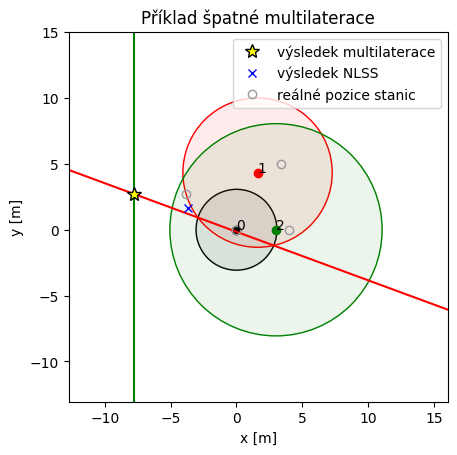

In [13]:
fig,ax = draw_multilateration_equations(anchor_outlier.iloc[-1]["chosen_anchors"], anchor_outlier.iloc[-1]["result_pos"])
lma_pos = lma(anchor_outlier.iloc[-1]["chosen_anchors"])
ax.plot(lma_pos[0], lma_pos[1], "xb", label="výsledek NLSS")
ax.plot(real.iloc[-4:]["x"], real.iloc[-4:]["y"], "o", fillstyle="none", color="0.6", label="reálné pozice stanic")
ax.legend()
ax.set_title("Příklad špatné multilaterace")
fig.savefig(f"{output_dir}finding-color-localization-error.png", dpi=300)

## Path

In [14]:
data_mobile = pd.read_json("logs/0020.json")
data_mobile.head()

,timestamp_start,timestamp_end,anchors,chosen_anchors,result_pos
0,40561,40811,"[{'x': -2.85, 'y': 2.47, 'dist': 12.66}, {'x':...",[],"[-14.548174, -2.370282]"
1,43321,43751,"[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[8.458903, -1.253097]"
2,46291,46691,"[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[11.046783, -0.738516]"
3,49151,49561,"[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[12.26312, -0.48957000000000006]"
4,52021,52501,"[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[10.799888, -1.876682]"


In [15]:
# convert "result_pos" to x and y columns
data_mobile["result_x"] = data_mobile["result_pos"].apply(lambda x: x[0])
data_mobile["result_y"] = data_mobile["result_pos"].apply(lambda x: x[1])
data_mobile.head()

,timestamp_start,timestamp_end,anchors,chosen_anchors,result_pos,result_x,result_y
0,40561,40811,"[{'x': -2.85, 'y': 2.47, 'dist': 12.66}, {'x':...",[],"[-14.548174, -2.370282]",-14.548174,-2.370282
1,43321,43751,"[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[8.458903, -1.253097]",8.458903,-1.253097
2,46291,46691,"[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[11.046783, -0.738516]",11.046783,-0.738516
3,49151,49561,"[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[12.26312, -0.48957000000000006]",12.263120,-0.489570
4,52021,52501,"[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[10.799888, -1.876682]",10.799888,-1.876682


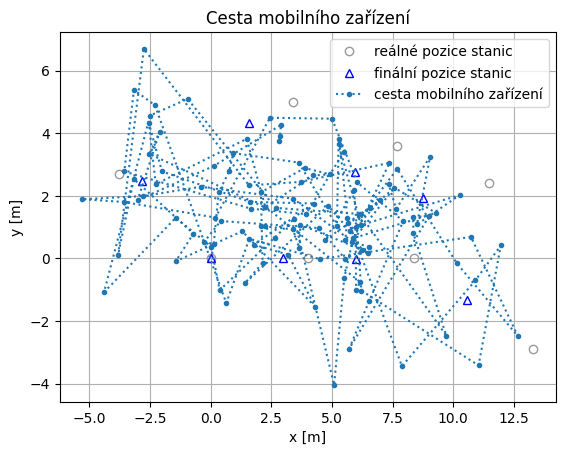

In [16]:
path_slice = data_mobile.iloc[20:-20]
plt.plot(real["x"], real["y"], "o", fillstyle="none", color="0.6", label="reálné pozice stanic")
plt.plot(final["x"], final["y"], "^b", fillstyle="none", label="finální pozice stanic")
plt.plot(path_slice["result_x"], path_slice["result_y"], ".:", label="cesta mobilního zařízení")
plt.gca().set_xlabel("x [m]")
plt.gca().set_ylabel("y [m]")
plt.gca().set_title("Cesta mobilního zařízení")
plt.legend()
plt.grid()
plt.savefig(f"{output_dir}finding-color-path.png", dpi=300)

In [17]:
outlier = [5, -4]
eps = 0.2
filtered_mobile_data = data_mobile.loc[(data_mobile["result_x"] > outlier[0] - eps) & (data_mobile["result_x"] < outlier[0] + eps)]
filtered_mobile_data = filtered_mobile_data.loc[(filtered_mobile_data["result_y"] > outlier[1] - eps) & (filtered_mobile_data["result_y"] < outlier[1] + eps)]
filtered_mobile_data.head()

,timestamp_start,timestamp_end,anchors,chosen_anchors,result_pos,result_x,result_y
53,198761,199171,"[{'x': 10.56, 'y': -1.34, 'dist': 4.16}, {'x':...","[{'x': 6.01, 'y': -0.01, 'dist': 1.68000000000...","[5.089761, -4.039553]",5.089761,-4.039553


A=[-3.01  0.01], b = -16.26735
(0, -1626.735), (5.404435215946845, 0), color=red
A=[ 4.55 -1.33], b = 31.3529
(0, -23.57360902255639), (6.890747252747252, 0), color=green
A=[-0.04  2.78], b = -15.664450000000002
(0, -5.634694244604318), (391.6112499999997, 0), color=blue
A=[-4.41  4.35], b = -36.44915
(0, -8.379114942528737), (8.265113378684807, 0), color=orange


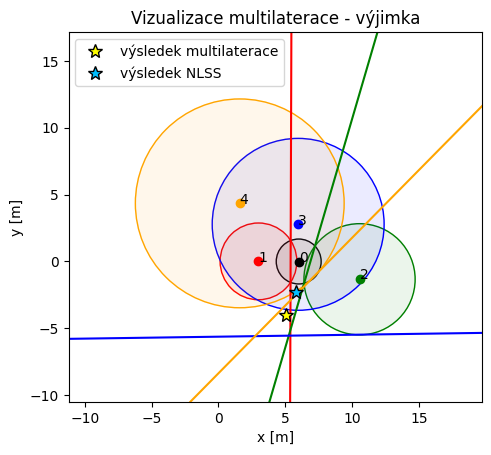

In [18]:
outlier_data = filtered_mobile_data.iloc[0]
fig, ax = draw_multilateration_equations(outlier_data["chosen_anchors"], outlier_data["result_pos"])
lma_pos = lma(outlier_data["chosen_anchors"])
ax.plot(lma_pos[0], lma_pos[1], "*", label="výsledek NLSS", markersize=10, markerfacecolor="deepskyblue", markeredgewidth=1, markeredgecolor="black")
ax.legend()
ax.set_title("Vizualizace multilaterace - výjimka")
fig.savefig(f"{output_dir}finding-color-multilateration-outlier.png", dpi=300)

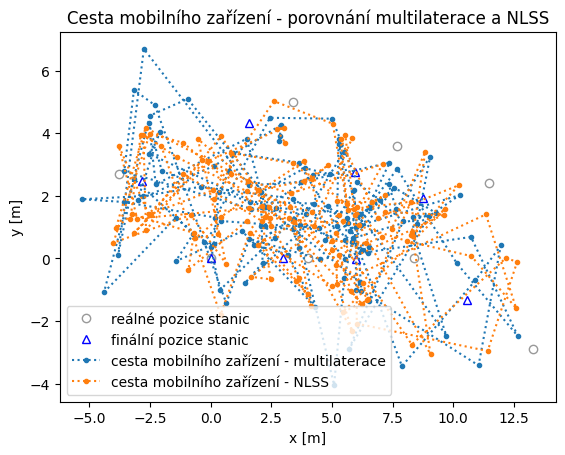

In [19]:
path_slice = data_mobile.iloc[20:-20]
lma_positions = path_slice["chosen_anchors"].apply(lma)
plt.plot(real["x"], real["y"], "o", fillstyle="none", color="0.6", label="reálné pozice stanic")
plt.plot(final["x"], final["y"], "^b", fillstyle="none", label="finální pozice stanic")
plt.plot(path_slice["result_x"], path_slice["result_y"], ".:", label="cesta mobilního zařízení - multilaterace")
plt.plot([x[0] for x in lma_positions], [x[1] for x in lma_positions], ".:", label="cesta mobilního zařízení - NLSS")
plt.gca().set_xlabel("x [m]")
plt.gca().set_ylabel("y [m]")
plt.gca().set_title("Cesta mobilního zařízení - porovnání multilaterace a NLSS")
plt.legend()
plt.savefig(f"{output_dir}finding-color-path-multilateration-nlss.png", dpi=300)

In [20]:
data_mobile2 = pd.read_json("logs/0020_2.json")
data_mobile2.head()

,timestamp_start,timestamp_end,anchors,chosen_anchors,result_pos
0,19981,20221,[],[],"[0.0, 0.0]"
1,22651,23121,"[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[7.20236, -9.097501]"
2,25621,26051,"[{'x': 10.56, 'y': -1.34, 'dist': 2.37}, {'x':...","[{'x': 6.01, 'y': -0.01, 'dist': 1.68000000000...","[6.79031, -0.432951]"
3,28591,29131,"[{'x': 10.56, 'y': -1.34, 'dist': 13.45}, {'x'...","[{'x': 6.01, 'y': -0.01, 'dist': 1.68000000000...","[4.411424, -0.034170000000000006]"
4,31561,32001,"[{'x': 10.56, 'y': -1.34, 'dist': 14.54}, {'x'...","[{'x': 3.0, 'y': 0.0, 'dist': 2.18}, {'x': 5.9...","[2.730997, 2.038924]"


In [21]:
# convert "result_pos" to x and y columns
data_mobile2["result_x"] = data_mobile2["result_pos"].apply(lambda x: x[0])
data_mobile2["result_y"] = data_mobile2["result_pos"].apply(lambda x: x[1])
data_mobile2.head()

,timestamp_start,timestamp_end,anchors,chosen_anchors,result_pos,result_x,result_y
0,19981,20221,[],[],"[0.0, 0.0]",0.000000,0.000000
1,22651,23121,"[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[7.20236, -9.097501]",7.202360,-9.097501
2,25621,26051,"[{'x': 10.56, 'y': -1.34, 'dist': 2.37}, {'x':...","[{'x': 6.01, 'y': -0.01, 'dist': 1.68000000000...","[6.79031, -0.432951]",6.790310,-0.432951
3,28591,29131,"[{'x': 10.56, 'y': -1.34, 'dist': 13.45}, {'x'...","[{'x': 6.01, 'y': -0.01, 'dist': 1.68000000000...","[4.411424, -0.034170000000000006]",4.411424,-0.034170
4,31561,32001,"[{'x': 10.56, 'y': -1.34, 'dist': 14.54}, {'x'...","[{'x': 3.0, 'y': 0.0, 'dist': 2.18}, {'x': 5.9...","[2.730997, 2.038924]",2.730997,2.038924


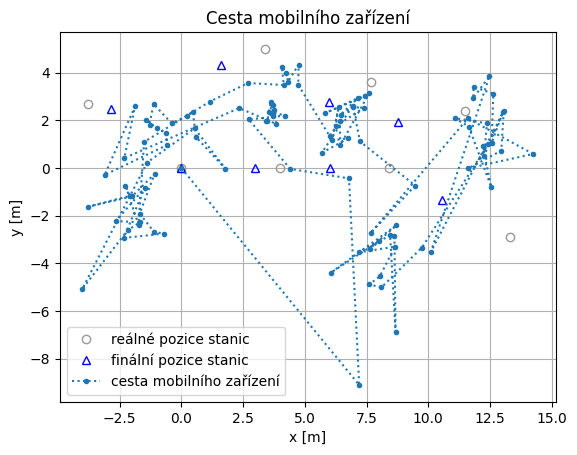

In [22]:
path_slice = data_mobile2
plt.plot(real["x"], real["y"], "o", fillstyle="none", color="0.6", label="reálné pozice stanic")
plt.plot(final["x"], final["y"], "^b", fillstyle="none", label="finální pozice stanic")
plt.plot(path_slice["result_x"], path_slice["result_y"], ".:", label="cesta mobilního zařízení")
plt.gca().set_xlabel("x [m]")
plt.gca().set_ylabel("y [m]")
plt.gca().set_title("Cesta mobilního zařízení")
plt.legend()
plt.grid()
# plt.savefig(f"{output_dir}finding-color-path.png", dpi=300)

A=[-4.37  1.57], b = -12.269099999999996
(0, -7.814713375796177), (2.8075743707093817, 0), color=red
A=[-2.97 -2.77], b = -19.372899999999998
(0, 6.993826714801443), (6.522861952861953, 0), color=green
A=[-5.97 -2.77], b = -28.749699999999997
(0, 10.378953068592057), (4.8156951423785594, 0), color=blue
A=[-8.82 -0.3 ], b = -32.40919999999999
(0, 108.0306666666667), (3.6745124716553277, 0), color=orange


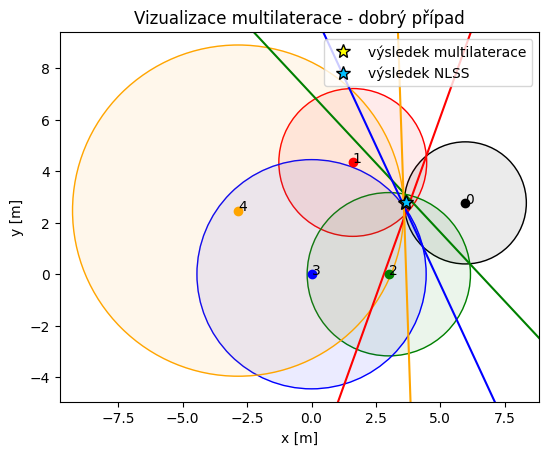

In [23]:
tmp_data = data_mobile2.iloc[11]
fig, ax = draw_multilateration_equations(tmp_data["chosen_anchors"], tmp_data["result_pos"], border=0.5)
lma_pos = lma(tmp_data["chosen_anchors"])
ax.plot(lma_pos[0], lma_pos[1], "*", label="výsledek NLSS", markersize=10, markerfacecolor="deepskyblue", markeredgewidth=1, markeredgecolor="black")
ax.legend()
ax.set_title(f"Vizualizace multilaterace - dobrý případ")
plt.show()
fig.savefig(f"{output_dir}finding-color-localization-good.png", dpi=300)